# Neurog Internship: (Task 4 - Implementation of Different Technical Indicators On 15 Minute Intervals, Then Making A Schedular That Generates Trading Signals After Every 15 Minutes)

## All Libraries

In [41]:
# For Vizualization & Plotting
import matplotlib.pyplot as plt

# Library For Technical Analysis
from ta.momentum import AwesomeOscillatorIndicator
from ta.volume import OnBalanceVolumeIndicator
from ta.momentum import RSIIndicator
from ta.trend import PSARIndicator
from ta.trend import ADXIndicator

# Other Necessary Libraries
import pandas as pd
import copy

## All Declarations

In [ ]:
# Define the relative path to the CSV file
csv_filename = "BTCUSDT_1_Minute_From_2020_To_Latest_Filtered.csv"

# Settig Up The Directory From The Directory Hierarchy
# Get the notebook's current directory
notebook_dir = os.path.dirname(os.path.abspath(__file__))

# Go up one level to the parent directory
parent_dir = os.path.dirname(script_dir)

# Create the full path to the output CSV file in the 'ohlc' directory within 'data'
data_dir = os.path.join(parent_dir, "data")
ohlc_dir = os.path.join(data_dir, "ohlc")
full_csv_path = os.path.join(ohlc_dir, csv_filename)

## (Function To Convert DF To Any Timeframe) - Taken From The Previous Day

In [24]:
# Functions converts the dataframe into any given time frame.
def convert_1m_to_any_timeframe(df: pd.DataFrame, timeframe: str) -> pd.DataFrame:
    """
    Convert a DataFrame of 1-minute OHLC data to any given timeframe.

    Args:
    - df (pd.DataFrame): DataFrame containing 1-minute OHLC data. 
      The DataFrame should have a datetime index & columns ['Open', 'High', 'Low', 'Close', 'Volume'].
    - timeframe (str): The desired timeframe to resample the data to (e.g., '1H' for 1 hour, '1D' for 1 day).

    Returns:
    - pd.DataFrame: Resampled DataFrame with OHLC data in the specified timeframe. The index will be renamed to
      reflect the new timeframe.

    Example:
    ```
    resampled_df = convert_1m_to_any_timeframe(ohlc_df, '1H')
    ```
    """
    # Ensure the DataFrame index is of datetime type
    df.index = pd.to_datetime(df.index)
    
    # Try resampling the data to the desired timeframe
    try:
        df_resampled = df.resample(timeframe).agg({
            'Open': 'first',  # Take the first 'Open' value in the timeframe
            'High': 'max',    # Take the maximum 'High' value in the timeframe
            'Low': 'min',     # Take the minimum 'Low' value in the timeframe
            'Close': 'last',  # Take the last 'Close' value in the timeframe
            'Volume': 'mean'  # Take the mean 'Volume' value in the timeframe
        })
    except Exception as e:
        print(f"An error occurred while resampling! Error message: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

    # Rename the index to reflect the new timeframe
    df_resampled.index.rename(f'Open time ({timeframe})', inplace = True)
    
    return df_resampled

## RSI Indicator Function

In [17]:
def calculate_rsi(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Relative Strength Index (RSI) using the ta library.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - window (int): The window size for calculating RSI, default is 14.

    Returns:
    - pd.DataFrame: DataFrame with the RSI values.
    """
    # Calculate RSI using ta library
    rsi_indicator = RSIIndicator(close=df['Close'], window=window, fillna=True)
    df['RSI'] = rsi_indicator.rsi()

    return df

def generate_signals(df: pd.DataFrame, rsi_lower: int = 20, rsi_upper: int = 80) -> pd.DataFrame:
    """
    Generate trading signals based on RSI values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'RSI' values.
    - rsi_lower (int): RSI lower threshold for buy signals, default is 30.
    - rsi_upper (int): RSI upper threshold for sell signals, default is 70.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['RSI'] > rsi_upper, 'Signal'] = -1  # Sell signal
    df.loc[df['RSI'] < rsi_lower, 'Signal'] = 1   # Buy signal

    return df

## MACD Indicator Function

In [94]:
def calculate_macd(df: pd.DataFrame, short_window: int = 12, long_window: int = 26, signal_window: int = 9) -> pd.DataFrame:
    """
    Calculate the MACD (Moving Average Convergence Divergence) for a given DataFrame.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' price data.
    - short_window (int): The window size for the short-term EMA, default is 12.
    - long_window (int): The window size for the long-term EMA, default is 26.
    - signal_window (int): The window size for the Signal line, default is 9.

    Returns:
    - pd.DataFrame: DataFrame with the MACD line and Signal line.
    """
    # Calculate the short-term and long-term EMAs
    df['EMA_12'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=long_window, adjust=False).mean()

    # Calculate the MACD line
    df['MACD'] = df['EMA_12'] - df['EMA_26']

    # Calculate the Signal line
    df['Signal_Line'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()

    return df

def generate_macd_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on MACD values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'MACD' and 'Signal_Line' values.

    Returns:
    - pd.DataFrame: DataFrame with trading signals.
    """
    df['Signal'] = 0  # Default no signal
    df.loc[df['MACD'] > df['Signal_Line'], 'Signal'] = 1  # Buy signal
    df.loc[df['MACD'] < df['Signal_Line'], 'Signal'] = -1  # Sell signal

    return df

## ADX In Combination With Parabolic SAR Indicator Function

In [19]:
def calculate_adx(df: pd.DataFrame, window: int = 14) -> pd.DataFrame:
    """
    Calculate the Average Directional Index (ADX) and add it to the DataFrame.
    
    Args:
    - df (pd.DataFrame): DataFrame containing 'High', 'Low', and 'Close' columns.
    - window (int): Window size for the ADX calculation (default is 14).
    
    Returns:
    - df (pd.DataFrame): DataFrame with added 'ADX' column.
    """
    adx = ADXIndicator(df['High'], df['Low'], df['Close'], window=window)
    df['ADX'] = adx.adx()
    df['DI+'] = adx.adx_pos()
    df['DI-'] = adx.adx_neg()
    return df

def calculate_parabolic_sar(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the Parabolic SAR and add it to the DataFrame.
    
    Args:
    - df (pd.DataFrame): DataFrame containing 'High', 'Low', and 'Close' columns.
    
    Returns:
    - df (pd.DataFrame): DataFrame with added 'Parabolic_SAR' column.
    """
    psar = PSARIndicator(df['High'], df['Low'], df['Close'])
    df['Parabolic_SAR'] = psar.psar()
    return df

def generate_adx_parabolic_sar_signals(df: pd.DataFrame, adx_threshold: float = 25) -> pd.DataFrame:
    """
    Generate trading signals based on ADX and Parabolic SAR.

    Args:
    - df (pd.DataFrame): DataFrame containing 'ADX' and 'Parabolic_SAR' columns.
    - adx_threshold (float): Threshold for ADX to consider a strong trend (default is 25).

    Returns:
    - df (pd.DataFrame): DataFrame with added 'Signal' column (1 for buy, -1 for sell, 0 for hold).
    """
    df['Signal'] = 0  # Default to hold
    df.loc[(df['ADX'] > adx_threshold) & (df['Close'] > df['Parabolic_SAR']), 'Signal'] = 1  # Buy signal
    df.loc[(df['ADX'] > adx_threshold) & (df['Close'] < df['Parabolic_SAR']), 'Signal'] = -1  # Sell signal
    return df

## On-Balance Volume (OBV) Indicator Function

In [20]:
def calculate_obv(df: pd.DataFrame, fillna: bool = False) -> pd.DataFrame:
    """
    Generate On-Balance Volume (OBV) Values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' and 'Volume' columns.
    - fillna (bool): Parameter that specifies whether or not to fill NaN values.

    Returns:
    - df (pd.DataFrame): DataFrame with added 'OBV' column.
    """
    obv = OnBalanceVolumeIndicator(
        close = df['Close'],
        volume = df['Volume'],
        fillna = True
    )
    
    df['OBV'] = obv.on_balance_volume()

    return df


def generate_obv_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on On-Balance Volume (OBV) indicator.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' and 'Volume' columns.
    - fillna (bool): Parameter that specifies whether or not to fill NaN values.

    Returns:
    - df (pd.DataFrame): DataFrame with added 'OBV' and 'Signal' columns.
    """
    df['Signal'] = 0  # Initialize Signal column
    
    # Generate signals based on OBV
    df.loc[df['OBV'] > df['OBV'].shift(1), 'Signal'] = 1  # Buy signal
    df.loc[df['OBV'] < df['OBV'].shift(1), 'Signal'] = -1  # Sell signal

    return df

## Awesome Oscillator Indicator

In [ ]:
def calculate_AO(df: pd.DataFrame, fillna: bool = False) -> pd.DataFrame:
    """
    Generate On-Balance Volume (OBV) Values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'Close' and 'Volume' columns.
    - fillna (bool): Parameter that specifies whether or not to fill NaN values.

    Returns:
    - df (pd.DataFrame): DataFrame with added 'OBV' column.
    """
    obv = AwesomeOscillatorIndicator(
        high = df['High'],
        low = df['Low'],
        fillna = True
    )
    
    df['AO'] = obv.awesome_oscillator()

    return df


def generate_AO_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate trading signals based on Awesome Oscillator (AO) values.

    Args:
    - df (pd.DataFrame): DataFrame containing 'AO' column. Should have a datetime index.

    Returns:
    - df (pd.DataFrame): DataFrame with added 'Signal' column indicating Buy (1), Sell (-1), or Hold (0) signals.
    """
    # Initialize Signal column with zeros
    df['Signal'] = 0
    
    # Generate signals based on AO
    for i in range(1, len(df)):
        if df['AO'].iloc[i] > 0 and df['AO'].iloc[i-1] <= 0:
            df.at[df.index[i], 'Signal'] = 1  # Buy signal
        elif df['AO'].iloc[i] < 0 and df['AO'].iloc[i-1] >= 0:
            df.at[df.index[i], 'Signal'] = -1  # Sell signal
    
    return df

## Main

### Reading The Previously Saved Data For BTCUSDT

In [9]:
BTCUSDT_Filtered_data_1M = pd.read_csv(full_csv_path)
BTCUSDT_Filtered_data_1M.set_index('Open time (1M)', inplace = True)

# Convert the index to datetime format
BTCUSDT_Filtered_data_1M.index = pd.to_datetime(BTCUSDT_Filtered_data_1M.index)

In [10]:
BTCUSDT_Filtered_data_1M

,Open,High,Low,Close,Volume
Open time (1M),,,,,
2020-01-01 00:00:00,7169.71,7169.71,7165.44,7167.83,3509.860
2020-01-01 00:01:00,7167.83,7168.28,7158.66,7159.95,3821.170
2020-01-01 00:02:00,7161.03,7165.40,7161.03,7162.46,3041.710
2020-01-01 00:03:00,7161.74,7164.27,7160.30,7161.03,3682.650
2020-01-01 00:04:00,7161.03,7164.25,7160.15,7160.15,2936.690
...,...,...,...,...,...
2024-06-25 12:07:00,63742.80,63742.80,62743.60,62743.60,1.216
2024-06-25 12:08:00,62743.60,63742.80,62652.60,62655.00,0.726
2024-06-25 12:09:00,62655.00,63742.80,62652.60,62652.60,2.820


### Display Graph For Close Price (1 Minute Interval)

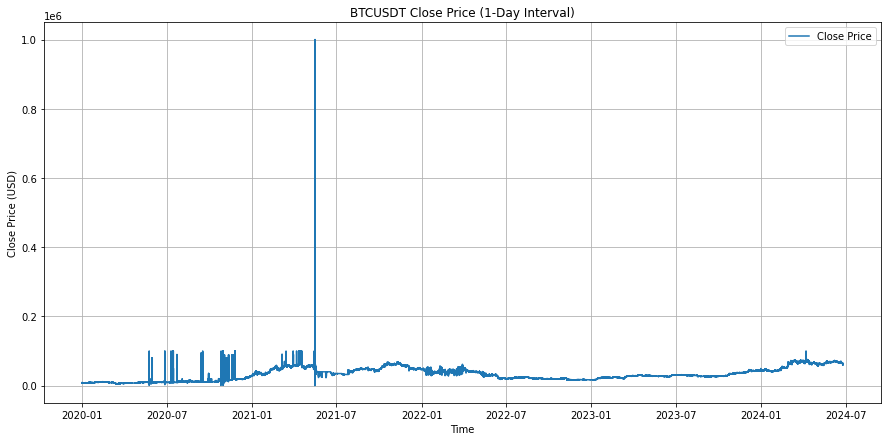

In [11]:
# Plot the 'Close' price over time
plt.figure(figsize=(15, 7))
plt.plot(BTCUSDT_Filtered_data_1M['Close'], label='Close Price')
plt.title('BTCUSDT Close Price (1-Minute Interval)')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### Display Graph For Volume (1 Minute Interval)

In [ ]:
# Plot the Volume over time
plt.figure(figsize=(15, 7))
plt.plot(BTCUSDT_Filtered_data_1M['Volume'], label='Volume')
plt.title('BTCUSDT Volume (1-Minute Interval)')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

## Now, Enough Plotting! On The Task!

### Changing The Timeframe to 15 Minutes

In [25]:
BTCUSDT_Filtered_data_15M = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M), '15T')
BTCUSDT_Filtered_data_15M

,Open,High,Low,Close,Volume
Open time (15T),,,,,
2020-01-01 00:00:00,7169.71,7169.71,7158.06,7160.58,3175.798000
2020-01-01 00:15:00,7160.58,7181.91,7156.65,7175.42,3502.250667
2020-01-01 00:30:00,7175.42,7178.00,7167.70,7172.51,3551.520000
2020-01-01 00:45:00,7171.80,7183.07,7166.33,7174.14,2573.803333
2020-01-01 01:00:00,7173.42,7180.14,7164.51,7167.89,3410.840400
...,...,...,...,...,...
2024-06-25 11:00:00,62666.40,63992.00,61804.00,63960.00,1.978400
2024-06-25 11:15:00,63350.10,63981.60,61904.00,62800.00,1.693267
2024-06-25 11:30:00,62999.70,63991.00,61981.60,63991.00,1.747867


### Selecting The Latest 675 Rows (Makes 45 / 46 Rows Of 15 Minute Interval Data)

In [78]:
BTCUSDT_Filtered_data_1M_Last_675_Rows = BTCUSDT_Filtered_data_1M.tail(675)
BTCUSDT_Filtered_data_1M_Last_675_Rows

,Open,High,Low,Close,Volume
Open time (1M),,,,,
2024-06-25 00:57:00,59557.0,60400.0,59006.4,59607.0,2.267
2024-06-25 00:58:00,59386.3,60000.0,59000.1,59111.7,356.578
2024-06-25 00:59:00,59482.0,59700.0,59000.1,59003.0,97.373
2024-06-25 01:00:00,59318.1,59500.0,59003.1,59499.9,8.221
2024-06-25 01:01:00,59499.9,59499.9,59284.0,59486.0,3.221
...,...,...,...,...,...
2024-06-25 12:07:00,63742.8,63742.8,62743.6,62743.6,1.216
2024-06-25 12:08:00,62743.6,63742.8,62652.6,62655.0,0.726
2024-06-25 12:09:00,62655.0,63742.8,62652.6,62652.6,2.820


### Changing To 15 Minute Interval Data

In [81]:
BTCUSDT_Filtered_data_15M_Of_675_Rows = convert_1m_to_any_timeframe(copy.deepcopy(BTCUSDT_Filtered_data_1M_Last_675_Rows), '15T')
BTCUSDT_Filtered_data_15M_Of_675_Rows

,Open,High,Low,Close,Volume
Open time (15T),,,,,
2024-06-25 00:45:00,59557.0,60400.0,59000.1,59003.0,152.072667
2024-06-25 01:00:00,59318.1,60449.8,59003.1,59300.2,6.160867
2024-06-25 01:15:00,59360.1,60499.2,59300.0,59300.0,27.569533
2024-06-25 01:30:00,59300.0,60641.9,59300.0,59306.0,22.582467
2024-06-25 01:45:00,59416.0,60641.8,59306.0,59522.5,3.035133
2024-06-25 02:00:00,60105.0,60546.1,59522.5,59622.0,4.178067
2024-06-25 02:15:00,60400.0,60500.0,59592.0,60419.4,2.303600
2024-06-25 02:30:00,60001.0,60500.0,59987.0,60007.0,7.486067
2024-06-25 02:45:00,60007.0,60500.0,59592.0,59944.7,4.514400


### Applying The Indicators On This DataFrame

In [82]:
# Calculate RSI for the 15-Minute data
BTCUSDT_Filtered_data_15M_with_rsi = calculate_rsi(copy.deepcopy(BTCUSDT_Filtered_data_15M_Of_675_Rows), window = 21)

# Generate trading signals based on RSI
BTCUSDT_Filtered_data_15M_with_rsi = generate_signals(BTCUSDT_Filtered_data_15M_with_rsi)

# Print the data with RSI and signals
BTCUSDT_Filtered_data_15M_with_rsi

,Open,High,Low,Close,Volume,RSI,Signal
Open time (15T),,,,,,,
2024-06-25 00:45:00,59557.0,60400.0,59000.1,59003.0,152.072667,100.000000,-1
2024-06-25 01:00:00,59318.1,60449.8,59003.1,59300.2,6.160867,100.000000,-1
2024-06-25 01:15:00,59360.1,60499.2,59300.0,59300.0,27.569533,99.929390,-1
2024-06-25 01:30:00,59300.0,60641.9,59300.0,59306.0,22.582467,99.930927,-1
2024-06-25 01:45:00,59416.0,60641.8,59306.0,59522.5,3.035133,99.962138,-1
2024-06-25 02:00:00,60105.0,60546.1,59522.5,59622.0,4.178067,99.968916,-1
2024-06-25 02:15:00,60400.0,60500.0,59592.0,60419.4,2.303600,99.987598,-1
2024-06-25 02:30:00,60001.0,60500.0,59987.0,60007.0,7.486067,75.383960,0
2024-06-25 02:45:00,60007.0,60500.0,59592.0,59944.7,4.514400,72.552162,0


In [83]:
# Calculate RSI for the 15-Minute data
BTCUSDT_Filtered_data_15M_with_macd = calculate_macd(copy.deepcopy(BTCUSDT_Filtered_data_15M_Of_675_Rows))

# Generate trading signals based on MACD
BTCUSDT_Filtered_data_15M_with_macd = generate_macd_signals(BTCUSDT_Filtered_data_15M_with_macd)

# Print the data with MACD, Signal line, and signals
BTCUSDT_Filtered_data_15M_with_macd

,Open,High,Low,Close,Volume,EMA_12,EMA_26,MACD,Signal_Line,MACD_Signal
Open time (15T),,,,,,,,,,
2024-06-25 00:45:00,59557.0,60400.0,59000.1,59003.0,152.072667,59003.000000,59003.000000,0.000000,0.000000,0
2024-06-25 01:00:00,59318.1,60449.8,59003.1,59300.2,6.160867,59048.723077,59025.014815,23.708262,4.741652,1
2024-06-25 01:15:00,59360.1,60499.2,59300.0,59300.0,27.569533,59087.381065,59045.384088,41.996977,12.192717,1
2024-06-25 01:30:00,59300.0,60641.9,59300.0,59306.0,22.582467,59121.014747,59064.688970,56.325777,21.019329,1
2024-06-25 01:45:00,59416.0,60641.8,59306.0,59522.5,3.035133,59182.781709,59098.600898,84.180811,33.651626,1
2024-06-25 02:00:00,60105.0,60546.1,59522.5,59622.0,4.178067,59250.353754,59137.371202,112.982552,49.517811,1
2024-06-25 02:15:00,60400.0,60500.0,59592.0,60419.4,2.303600,59430.207023,59232.336298,197.870724,79.188394,1
2024-06-25 02:30:00,60001.0,60500.0,59987.0,60007.0,7.486067,59518.944404,59289.718795,229.225609,109.195837,1
2024-06-25 02:45:00,60007.0,60500.0,59592.0,59944.7,4.514400,59584.445265,59338.235921,246.209344,136.598538,1


In [84]:
# Calculate ADX and Parabolic SAR
BTCUSDT_Filtered_data_15M_with_adx = calculate_adx(copy.deepcopy(BTCUSDT_Filtered_data_15M_Of_675_Rows), window = 14)
BTCUSDT_Filtered_data_15M_with_adx_and_sar = calculate_parabolic_sar(BTCUSDT_Filtered_data_15M_with_adx)

# Generate trading signals
BTCUSDT_Filtered_data_15M_with_adx_and_sar = generate_adx_parabolic_sar_signals(BTCUSDT_Filtered_data_15M_with_adx_and_sar)

# Print the data with adx and sar
BTCUSDT_Filtered_data_15M_with_adx_and_sar

,Open,High,Low,Close,Volume,ADX,DI+,DI-,Parabolic_SAR,Signal
Open time (15T),,,,,,,,,,
2024-06-25 00:45:00,59557.0,60400.0,59000.1,59003.0,152.072667,0.000000,0.000000,0.000000,59003.000000,0
2024-06-25 01:00:00,59318.1,60449.8,59003.1,59300.2,6.160867,0.000000,0.000000,0.000000,59300.200000,0
2024-06-25 01:15:00,59360.1,60499.2,59300.0,59300.0,27.569533,0.000000,0.000000,0.000000,60400.000000,0
2024-06-25 01:30:00,59300.0,60641.9,59300.0,59306.0,22.582467,0.000000,0.000000,0.000000,59300.000000,0
2024-06-25 01:45:00,59416.0,60641.8,59306.0,59522.5,3.035133,0.000000,0.000000,0.000000,60641.900000,0
2024-06-25 02:00:00,60105.0,60546.1,59522.5,59622.0,4.178067,0.000000,0.000000,0.000000,60641.900000,0
2024-06-25 02:15:00,60400.0,60500.0,59592.0,60419.4,2.303600,0.000000,0.000000,0.000000,60641.800000,0
2024-06-25 02:30:00,60001.0,60500.0,59987.0,60007.0,7.486067,0.000000,0.000000,0.000000,60615.084000,0
2024-06-25 02:45:00,60007.0,60500.0,59592.0,59944.7,4.514400,0.000000,0.000000,0.000000,60588.902320,0


In [86]:
# Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
BTCUSDT_Filtered_data_15M_with_obv = calculate_obv(copy.deepcopy(BTCUSDT_Filtered_data_15M_Of_675_Rows))
BTCUSDT_Filtered_data_15M_with_obv = generate_obv_signals(BTCUSDT_Filtered_data_15M_with_obv)
BTCUSDT_Filtered_data_15M_with_obv

,Open,High,Low,Close,Volume,OBV,Signal
Open time (15T),,,,,,,
2024-06-25 00:45:00,59557.0,60400.0,59000.1,59003.0,152.072667,152.072667,0
2024-06-25 01:00:00,59318.1,60449.8,59003.1,59300.2,6.160867,158.233533,1
2024-06-25 01:15:00,59360.1,60499.2,59300.0,59300.0,27.569533,130.664000,-1
2024-06-25 01:30:00,59300.0,60641.9,59300.0,59306.0,22.582467,153.246467,1
2024-06-25 01:45:00,59416.0,60641.8,59306.0,59522.5,3.035133,156.281600,1
2024-06-25 02:00:00,60105.0,60546.1,59522.5,59622.0,4.178067,160.459667,1
2024-06-25 02:15:00,60400.0,60500.0,59592.0,60419.4,2.303600,162.763267,1
2024-06-25 02:30:00,60001.0,60500.0,59987.0,60007.0,7.486067,155.277200,-1
2024-06-25 02:45:00,60007.0,60500.0,59592.0,59944.7,4.514400,150.762800,-1


In [87]:
# Assuming 'BTCUSDT_Filtered_data_1D' is your DataFrame with 'Close' and 'Volume' columns
BTCUSDT_Filtered_data_15M_with_ao = calculate_AO(copy.deepcopy(BTCUSDT_Filtered_data_15M_Of_675_Rows))
BTCUSDT_Filtered_data_15M_with_ao = generate_AO_signals(BTCUSDT_Filtered_data_15M_with_ao)
BTCUSDT_Filtered_data_15M_with_ao

,Open,High,Low,Close,Volume,AO,Signal
Open time (15T),,,,,,,
2024-06-25 00:45:00,59557.0,60400.0,59000.1,59003.0,152.072667,0.000000,0
2024-06-25 01:00:00,59318.1,60449.8,59003.1,59300.2,6.160867,0.000000,0
2024-06-25 01:15:00,59360.1,60499.2,59300.0,59300.0,27.569533,0.000000,0
2024-06-25 01:30:00,59300.0,60641.9,59300.0,59306.0,22.582467,0.000000,0
2024-06-25 01:45:00,59416.0,60641.8,59306.0,59522.5,3.035133,0.000000,0
2024-06-25 02:00:00,60105.0,60546.1,59522.5,59622.0,4.178067,36.831667,1
2024-06-25 02:15:00,60400.0,60500.0,59592.0,60419.4,2.303600,77.628571,0
2024-06-25 02:30:00,60001.0,60500.0,59987.0,60007.0,7.486067,104.386250,0
2024-06-25 02:45:00,60007.0,60500.0,59592.0,59944.7,4.514400,108.656667,0


### The Schdular Is Implemented In VS Code

# ***More Later!***